<img src="M_earth.png"
     width="120" height="120"
     style="float: right; margin-right: 5px;" />
     
# Intro to Distributed Acoustic Sensing (DAS) data


---

## Introduction
In this notebook, we will introduce some DAS data analysis using two dataset in HDF5 format. The first part is to read one DAS earthquake data from Mexico and conduct some basic processing to understand DAS data. The second part gives one example of ocean bottom DAS and visulizes it in frequency-wavenumber (f-k) domain.

**Contents:**
- DAS earthquake data from Mexico City
- Ocean bottom DAS data in f-k plot

**Objectives:** 
- Get started with DAS 
- Read and visualize DAS data
- Analyze data in frequency domain 

---

## Part 1. DAS earthquake data from Mexico City

In [1]:
import h5py
import numpy as np
import string
import glob
import os, psutil
import time

from scipy import signal
import scipy.fftpack as fft
from scipy.fftpack import fft2,ifft2, fftshift,ifftshift, fftfreq

import obspy
from obspy import UTCDateTime as UTC
from obspy.signal.filter import bandpass
from obspy.signal.tf_misfit import plot_tfr

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'axes.titlesize': 'x-large',
         'image.cmap': 'RdBu'
         }
pylab.rcParams.update(params)

### Reading DAS data using h5py

In [3]:
# Read the DAS data and check keys in it
h5 = h5py.File('Mw_4.7_raw.h5', 'r')
h5.keys()

<KeysViewHDF5 ['Channels', 'DAS', 't']>

In [4]:
# Print data information
chan = h5['Channels'][()]
t = h5['t'][()]
DAS = h5['DAS'][()] 

fs = 1/(t[1]-t[0]) # sampling rate
print('Channels start from {:3d} to {:3d}.'.format(chan[0], chan[-1]))
print('The duration of the time series is {:.1f} s with a sampling rate of {:.1f} Hz.'
        .format(t[-1], fs))
print('This DAS data has a shape of', np.shape(DAS))
h5.close()

Channels start from 100 to 2265.
The duration of the time series is 190.0 s with a sampling rate of 200.0 Hz.
This DAS data has a shape of (2166, 38000)


### Visualizing DAS data

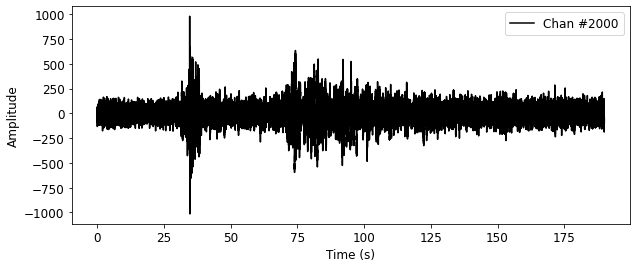

In [5]:
# Plot data recorded by one single channel
# Example: Chan #1000
chan_id = 2000
das_tr = DAS[chan_id-100]
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(t, das_tr, color='black', label='Chan #'+str(chan_id))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.legend()
plt.show()

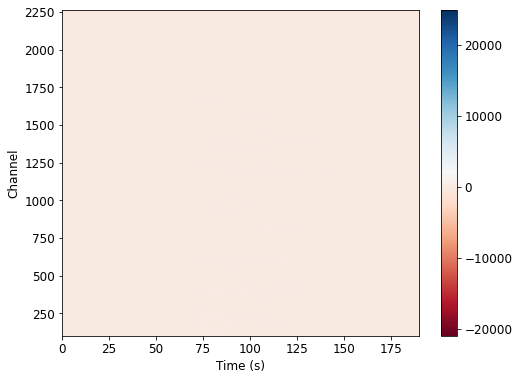

In [6]:
# Plot 2-D DAS data using imshow
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(DAS, aspect='auto', extent=[min(t),max(t), min(chan), max(chan)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Channel')
plt.colorbar(im, ax=ax)
plt.show()

In [7]:
# Determining Upper and Lower Limits of the Data
vm = np.percentile(DAS, 90)
std = np.std(DAS)
print("The max and min amplitude is {:.4f}, {:.4f}"
.format(DAS.min(), DAS.max()))
print("The 90th percentile is {:.4f}; the standard deviation is {:.4f}."
.format(vm, std))

The max and min amplitude is -20963.6802, 24966.6863
The 90th percentile is 107.6554; the standard deviation is 223.5351.


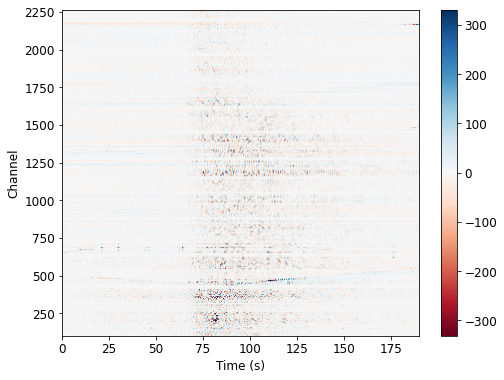

In [8]:
# Use vmin and vmax to define the data range that the colormap covers
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(DAS, aspect='auto', vmin=-vm-std, vmax=vm+std, extent=[min(t),max(t), min(chan), max(chan)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Channel')
plt.colorbar(im, ax=ax)
plt.show()

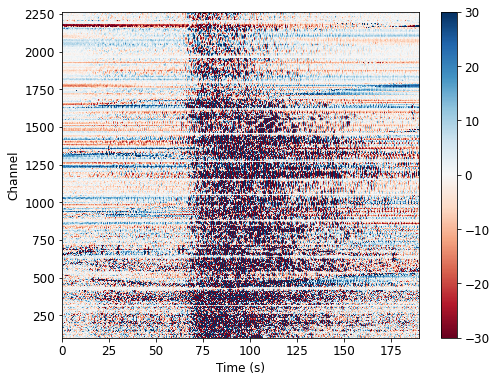

In [9]:
# It's more obvious to use narrow data range 
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(DAS, aspect='auto', vmin=-30, vmax=30, extent=[min(t),max(t), min(chan), max(chan)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Channel')
plt.colorbar(im, ax=ax)
plt.show()

In [10]:
# Enhance the signal by averaging nearby channels

def das_ave_2Nadd1(DAS, N):
    """
    Enhance the signal through averaging data from surrounding channels [-N, N]
    The mean trace will be obtained by 2N+1 total traces
    Parameters:
    ------------
    DAS: - DAS data with shape of [c, t], 
         - c is the number of channels and t is the number of sampling points.
    N  : Number of channels before and after one trace.
    """

    DAS = np.concatenate((DAS[:N], DAS, DAS[-N:]))
    das_ave = [] #np.zeros(DAS.shape, DAS.dtype)
    for chan in range(N, DAS.shape[0]-N):
        if chan==N:
            sum_tr = np.sum(DAS[:2*N+1],axis=0)
        else:
            sum_tr = sum_tr - DAS[chan-N-1] + DAS[chan+N]

        das_ave.append(sum_tr)
    das_ave = np.array(das_ave)/(2*N+1)
    
    return das_ave

def plot_2_das(das1, das2, t, chan, title1='Raw data', title2='Data 2'):
    """
    Plot two DAS data 
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True, )
    im0 = ax[0].imshow(das1, aspect='auto', vmin=-30, vmax=30, 
                extent=[min(t),max(t), min(chan), max(chan)])
    im1 = ax[1].imshow(das2, aspect='auto', vmin=-30, vmax=30, 
                extent=[min(t),max(t), min(chan), max(chan)])
    ax[0].set_xlabel('Time (s)')
    ax[1].set_xlabel('Time (s)')
    ax[0].set_ylabel('Channel')
    ax[0].set_title(title1)
    ax[1].set_title(title2)

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", "4%", pad="3%")
    fig.colorbar(im1, cax=cax)
    fig.tight_layout()
    plt.show()     

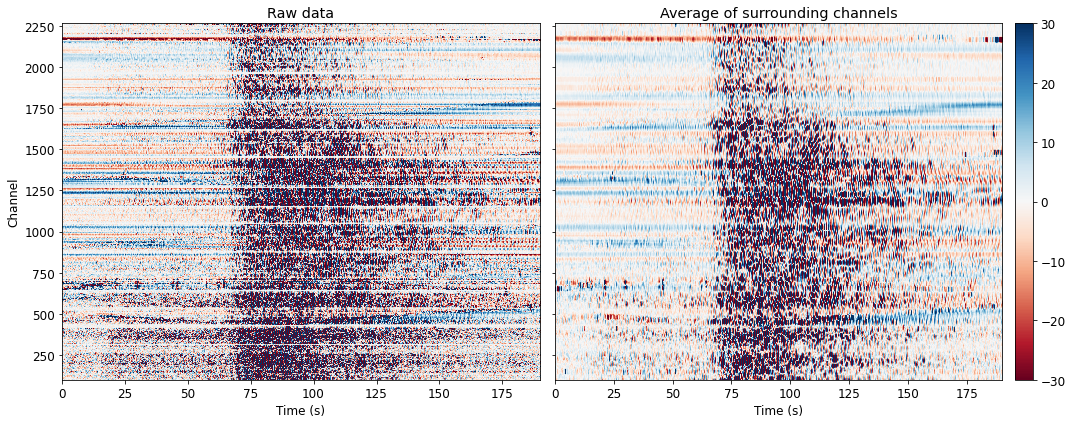

In [11]:
das_ave = das_ave_2Nadd1(DAS, N=15)
plot_2_das(DAS, das_ave, t, chan, title2='Average of surrounding channels')

### Spectral analysis

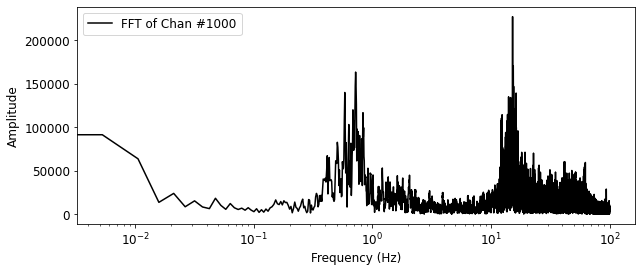

In [12]:
chan_id = 1000
das_tr = DAS[chan_id-100]

tr_fft = fft.fft(das_tr)
f_len = int(tr_fft.size/2)
NqF = fs/2.0  #the Nyquist frequency
frequency = np.linspace(0, NqF, num=f_len)

fig, ax = plt.subplots(figsize=(10, 4))
ax.semilogx(frequency, abs(tr_fft[:f_len]), color='black', 
            label='FFT of Chan #'+str(chan_id))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
ax.legend()
plt.show()

/Applications/anaconda3/envs/granada_das/lib/python3.8/site-packages/obspy/signal/tf_misfit.py:1501: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img_tfr = ax_tfr.pcolormesh(x, y, _tfr[itr], cmap=cmap)


<Figure size 720x576 with 0 Axes>

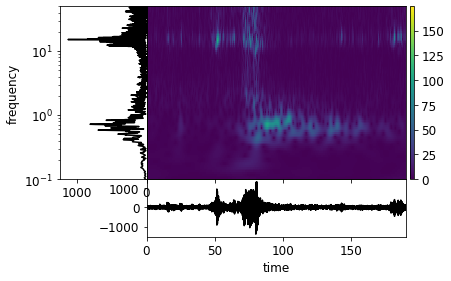

In [13]:
# Plot time frequency representation, spectrum and time series of the signal.
fmin = 0.1
fmax = 50
plt.figure(figsize=(10, 8))
plot_tfr(das_tr, dt=1/fs, fmin=fmin, fmax=fmax)

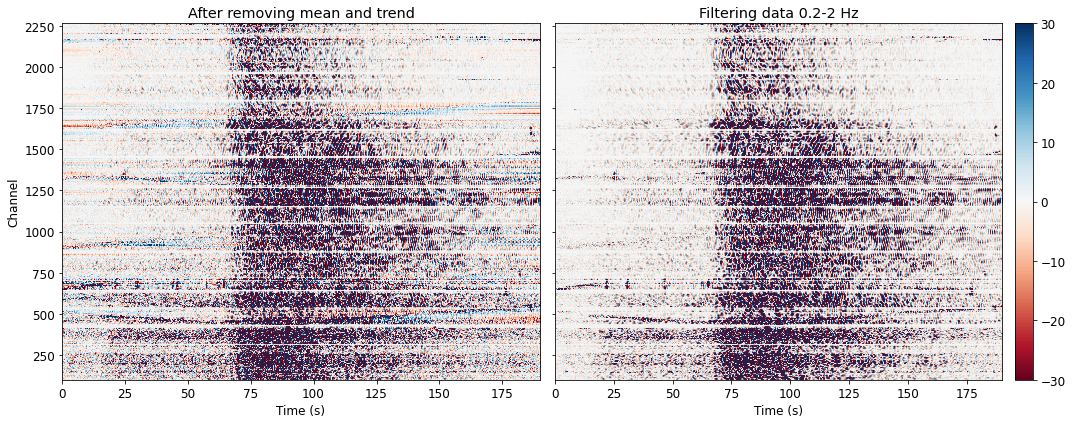

In [14]:
# Perform basic processing  
# demean, detrend, filtering
das_pro = DAS - DAS.mean(axis=1, keepdims=True)
das_pro = signal.detrend(das_pro,type='constant')
das_pro = signal.detrend(das_pro,type='linear')

fmin1 = 0.2; fmax1 = 2;
das_filt1 = np.float32(bandpass(das_pro, fmin1, fmax1, 
                                df=fs, corners=4, zerophase=True))
plot_2_das(das_pro, das_filt1, t, chan, 
            title1='After removing mean and trend', 
            title2='Filtering data '+str(fmin1)+'-'+str(fmax1)+' Hz')

### Resampling data


In [15]:
# downsampling data from 200 to 50 Hz
new_sampling_rate = 50 
decimate_s = int(fs/new_sampling_rate)
das_dws = signal.decimate(das_pro, decimate_s, ftype='iir', zero_phase=True)
print('The shape of downsampling data is', das_dws.shape)

The shape of downsampling data is (2166, 9500)


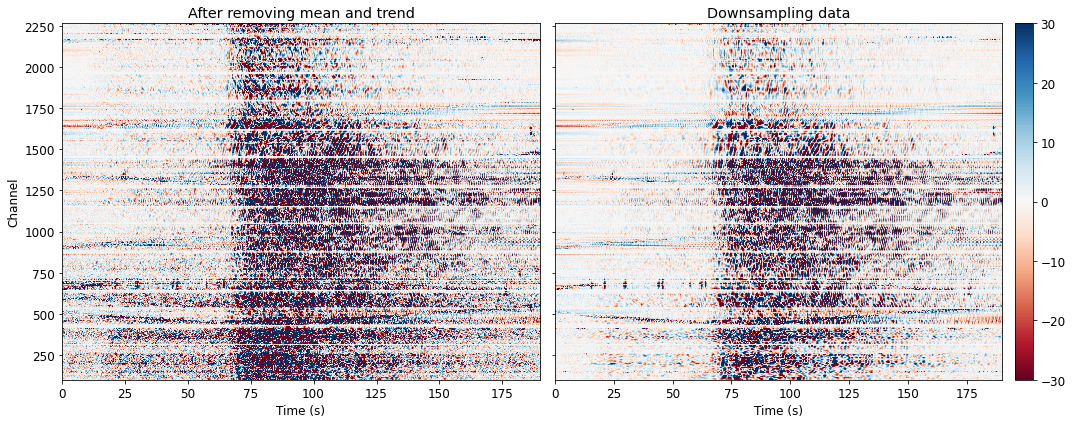

In [16]:
plot_2_das(das_pro, das_dws, t, chan, 
            title1='After removing mean and trend',          
            title2='Downsampling data')

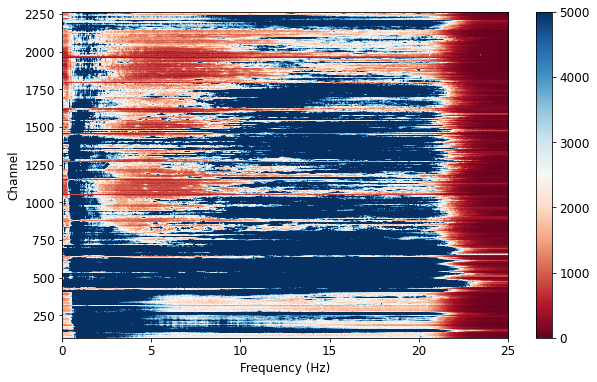

In [17]:
# Takes some time to calculate FFT of all traces
for ii, das_tr in enumerate(das_dws):
    if ii==0:
        tr_fft = fft.fft(das_tr)
        f_len = int(tr_fft.size/2)
        NqF = new_sampling_rate/2.0  #the Nyquist frequency
        frequency = np.linspace(0, NqF, num=f_len)
        tr_fft = abs(tr_fft[:f_len]) 
    else:
        tr_fft=np.vstack((tr_fft, abs(fft.fft(das_tr)[:f_len])))
        
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(tr_fft, aspect='auto', vmin=0, vmax=5e3,
          extent=[0, frequency[-1], min(chan), max(chan)])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Channel')
#ax.set_xscale('log')
ax.set_xlim([0, frequency[-1]])
plt.colorbar(im, ax=ax)
plt.show()

## Part 2. Ocean Bottom DAS and f-k plot

In [18]:
### Each file is 5-min long. 
# Here we read two files for Ch. 100-700 only and concatenate. 
folder = './' # change iy to your own folder with all files
#data1=h5py.File(folder+'0000002830_2019-11-18_06.27.08.86990.hdf5','r')['DAS'][:,100:700]
#data2=h5py.File(folder+'0000002832_2019-11-18_06.32.08.86990.hdf5','r')['DAS'][:,100:700]
#data=np.concatenate((data1,data2))

In [ ]:
### Save data in a new file
#with h5py.File(folder+'raw_10min_ch100-700_500hz.hdf5', 'w') as hdf:
#    hdf.create_dataset('DAS',data=data)
#    hdf.create_dataset('starttime',data='2019-11-18_06.27.08.86990')

In [19]:
data = h5py.File('raw_10min_ch100-700_500hz.hdf5', 'r')

### Conversion

In [20]:
def convert(data):
    """
    Convert raw data to strain rate
    
    The raw data is phase shift, scaled from -32768 to 32768, corresponding -pi to pi. 
    Phase shift needs to be converted to pi-scale and cumsum-ed to get phase data. 
    Phase data are then transformed into strain measurements by multiple a linear scaler,
    which is determined by laser wavelenght, fiber refractive index, gauge length and optical-elastic coefficient.
    Strain rate are also be calculated by differentiation.
    """
    phase=np.cumsum(data*np.pi/32768,dtype='float')
    strain=phase*1550*10**-9/(4*np.pi*1.47*0.78*40)
    
    strain_rate=[0]
    for i in range(1,len(strain)):
        strain_rate.append((strain[i]-strain[i-1])*500)
    
    return strain_rate

In [21]:
### Read data (raw, 500hz)
phase_500hz=h5py.File(folder+'raw_10min_ch100-700_500hz.hdf5','r')['DAS'][:,:]

### Convert from raw to SR (500hz)
sr_500hz=np.empty((phase_500hz.shape[0],phase_500hz.shape[1]))

for i in range(phase_500hz.shape[1]):
    sr_500hz[:,i]=convert(phase_500hz[:,i])

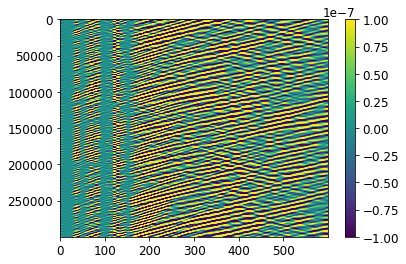

In [22]:
plt.imshow(sr_500hz,aspect='auto',cmap='viridis', vmin=-0.1*10**-6,vmax=0.1*10**-6)
plt.colorbar()

In [ ]:
### Save SR data
with h5py.File(folder+'sr_10min_ch100-700_500hz.hdf5', 'w') as hdf:
    hdf.create_dataset('sr',data=sr_500hz)
    hdf.create_dataset('starttime',data='2019-11-18_06.27.08.86990')

In [23]:
def taper(data, taper_dur, fs ):
    
    ### Hann taper with a width of 0.5*taper_dur
    
    hann_func = signal.hann(int(int(taper_dur*2)*fs)+1) 
    half_len = round(len(hann_func)/2-.001)
    data[:half_len] = data[:half_len]*hann_func[:half_len]
    data[-half_len:] = data[-half_len:]*hann_func[-half_len:]
    return data

def decimate(stream_data,factor: list,taper_dur,fs):
    """
    decimate and tape the data
    
    Note that the input factor should be a list, containing a series of decimation factor.
    If decimation factor is larger than 10, it should be done in two or more steps.
    Eg. Instead of factor=[10], we do factor=[2,5]
    """ 
    out_data=stream_data[:,0]
    out_data=taper(out_data,taper_dur,fs)
    temp_fs=fs
    
    for f in factor:
        temp_fs=int(temp_fs/f)
        out_data=signal.decimate(out_data,f,ftype='iir', zero_phase=True,axis=0)
        out_data=taper(out_data,taper_dur,temp_fs)
    
    for i in range(1,stream_data.shape[-1]):
        
        trace_data=stream_data[:,i]
        trace_data=taper(trace_data,taper_dur,fs)
        temp_fs=fs
        
        for f in factor:
            temp_fs=int(temp_fs/f)
            trace_data=signal.decimate(trace_data,f,ftype='iir', zero_phase=True,axis=0)
            trace_data=taper(trace_data,taper_dur,temp_fs)
            
        out_data=np.vstack((out_data,trace_data))
        
    return out_data.T

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    
    ### forth order butterworth bandpass filter
    
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    y = signal.filtfilt(b, a, data)
    return y

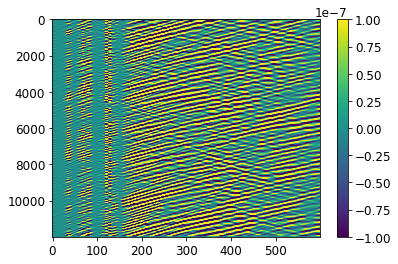

In [24]:
### Decimate SR data from 500hz to 25hz
sr_20hz=decimate(sr_500hz,[5,5],4,500)

plt.imshow(sr_20hz,aspect='auto',cmap='viridis',vmin=-0.1*10**-6,vmax=0.1*10**-6)
plt.colorbar()
plt.show()


In [ ]:
### Save data
with h5py.File(folder+'sr_10min_ch100-700_20hz.hdf5', 'w') as hdf:
    hdf.create_dataset('sr',data=sr_20hz)
    hdf.create_dataset('starttime',data='2019-11-18_06.27.08.86990')

### f-k plot

In [25]:
### FK plot visualizes the spectrum in both spatial and temporal domain.
### Here we do a 2D fourier transform and covnert fourier amplitudes into log scale. 

spec=np.fft.fftshift(np.fft.fft2(sr_20hz[:,200:]))
psd=10*np.log10(spec)

In [26]:
### Create meshgrid for plotting. 
### Here the SR data is 20 Hz, so the temporal resolution is 0.05s. Spatial resolution (channel spacing) is 5m.

xs1=np.fft.fftfreq(12000,0.05)[0:500]
xs2=np.fft.fftfreq(12000,0.05)[-500:]
xs=np.concatenate((xs2,xs1))

ys=np.fft.fftfreq(400,5)[0:200]

X,Y=np.meshgrid(xs,ys)

### Create a theoritical water wave dispersion relation for reference

xp=np.arange(0,0.6,0.001)
xn=-1*xp

xl=(9.8*ys*2*np.pi*np.tanh(ys*100*2*np.pi))**0.5/(2*np.pi)
xln=-(9.8*ys*2*np.pi*np.tanh(ys*100*2*np.pi))**0.5/(2*np.pi)

/var/folders/_w/l4s6fg193b94w726vx60vxx40000gn/T/ipykernel_75188/50895664.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X,Y,np.flip(psd.real[5500:6500,0:200].T,axis=0),cmap=cmap,zorder=0,vmin=-40,vmax=-15)


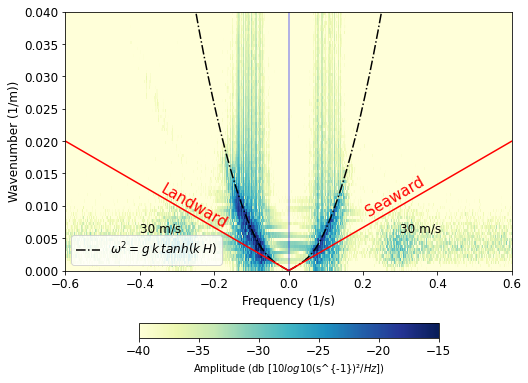

In [27]:
formula=r'\omega^2= g\:k\:tanh(k\:H)'

cmap = plt.get_cmap('YlGnBu')

plt.figure(figsize=(8,6))
plt.xlim((-0.6,0.6))
plt.ylim((0,0.04))
plt.pcolormesh(X,Y,np.flip(psd.real[5500:6500,0:200].T,axis=0),cmap=cmap,zorder=0,vmin=-40,vmax=-15)

cbar=plt.colorbar(orientation="horizontal",fraction=0.046,pad=0.16)
cbar.set_label('Amplitude (db [$10 log10($s^{-1}$)\u00b2/Hz$])',fontsize=10)

plt.xlabel('Frequency (1/s)',fontsize=12)
plt.ylabel('Wavenumber (1/m))',fontsize=12)
plt.plot(xl,ys,'black',linestyle='-.',label='$%s$' %formula)
plt.plot(xln,ys,'black',linestyle='-.')
plt.plot(xp,xp/30,c='r')
plt.plot(xn,-xn/30,c='r')
plt.axvline(x=0,c='b',alpha=0.4)

plt.text(0.3,0.006,'30 m/s',fontsize=12)
plt.text(-0.4,0.006,'30 m/s',fontsize=12)
plt.text(0.2,0.0085,'Seaward',size=15,c='r',rotation=30)
plt.text(-0.35,0.0065,'Landward',size=15,c='r',rotation=330)
plt.legend()
plt.show()

**References:**
- [IntroToDASData](https://github.com/DAS-RCN/IntroToDASData)
- [roses2021 DAS with Dr. Eileen Martin](https://connect.agu.org/seismology/roses/roses2021materials)
- [NoisePy](https://noise-python.readthedocs.io/en/latest/)